# Drone Simulator

In [1]:
%matplotlib notebook

from py_drone_module import Drone, DroneReference, DroneReferenceFunction, AdaptiveODEOptions
from py_drone_module import eul2quat, quatmultiply, quatconjugate
from py_drone_module import GaussianNoiseGeneratorInput, GaussianNoiseGeneratorOutput
from plot_simulation.DroneParamsAndMatricesBuilder import buildDroneParamsAndMatrices
from numpy import array, diag
import numpy as np
from math import pi
from plot_simulation.quat_params import quat_params
import plot_simulation.Reference
import DronePlotter
import matplotlib.pyplot as plt
import time
import copy

from ipywidgets import interact, interactive
import ipywidgets as widgets

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95vw !important; }</style>"))

### Attitude and Altitude Controller Settings

In [2]:
Q_att = diag((139.6245112700232,
              139.6245112700232,
              15.2811761590895,
              1.1505204155597211,
              1.1505204155597211,
              0.1209919487616804,
              9.976475759487083e-08,
              9.976475759487083e-08,
              9.976475759487083e-09))
R_att = diag((8, 8, 8))
K_pi_alt = array((0.0, 0.9, 0.5, 0.1))
maxIntegral = 10

varDynamics_att = array(((1e-4, 1e-4, 1e-6),))
varSensors_att = np.transpose(
    np.concatenate((
        eul2quat(pi / 180.0 * np.ones(3)),
        0.005 * np.ones((3,1)))))
print(varDynamics_att)
print(varSensors_att)

varDynamics_alt = array(((1e-1,),))
varSensors_alt = array(((1e-2,),))
print(varDynamics_alt)
print(varSensors_alt)

varDynamics_nav = np.zeros((1,0))
varSensors_nav = np.zeros((1,2))
print(varDynamics_nav)
print(varSensors_nav)

# I used a smaller varDynamics_alt here
varDynamics = np.concatenate((varDynamics_att, varDynamics_alt / 100, varDynamics_nav), axis=1)
varSensors = np.concatenate((varSensors_att, varSensors_alt, varSensors_nav), axis=1)

randFnW = GaussianNoiseGeneratorInput(varDynamics)
randFnV = GaussianNoiseGeneratorOutput(varSensors)

# randFnW = GaussianNoiseGeneratorInput(np.zeros((1,4)))
# randFnV = GaussianNoiseGeneratorOutput(np.zeros((1,10)))

[[1.e-04 1.e-04 1.e-06]]
[[0.99988644 0.00864972 0.00880202 0.00864972 0.005      0.005
  0.005     ]]
[[0.1]]
[[0.01]]
[]
[[0. 0.]]


### Drone Model and Controllers

In [3]:
p = quat_params()
dp = buildDroneParamsAndMatrices(p)
d = Drone(dp)
controller = d.getController(Q_att, R_att, K_pi_alt, maxIntegral)
observer = d.getObserver(varDynamics_att, varSensors_att,
                         varDynamics_alt, varSensors_alt)

### Reference

In [4]:
def get_reference(t):
    m = 0.5  # time scale factor

    qz = eul2quat((8*pi/180, 0, 0))
    qy = eul2quat((0, 8*pi/180, 0))
    qx = eul2quat((0, 0, 8*pi/180))
    q = eul2quat((0, 0, 0))

    if (t >= m * 1 and t < m * 3):
        q = quatmultiply(q, qz)
    if (t >= m * 5 and t < m * 7):
        q = quatmultiply(q, qy)
    if (t >= m * 9 and t < m * 11):
        q = quatmultiply(q, qx)

    if (t >= m * 13 and t < m * 15):
        q = quatmultiply(q, quatconjugate(qy))
    if (t >= m * 17 and t < m * 19):
        q = quatmultiply(q, quatconjugate(qx))
    if (t >= m * 21 and t < m * 23):
        q = quatmultiply(q, quatconjugate(qz))

    if (t >= m * 27 and t < m * 30):
        q = quatmultiply(q, qy)
    if (t >= m * 28 and t < m * 31):
        q = quatmultiply(q, qx)

    if (t >= m * 33 and t < m * 36):
        q = quatmultiply(q, quatconjugate(qx))
    if (t >= m * 34 and t < m * 37):
        q = quatmultiply(q, quatconjugate(qy))

    rr = DroneReference()
    rr.setOrientation(q)
    rr.setPosition((0, 0, 1.0 * (t >= m * 8)))
    return rr.asColVector()

ref_function = DroneReferenceFunction(get_reference)

### Initial Conditions and Integration Options

In [5]:
x0 = d.getStableState()

odeopt = AdaptiveODEOptions()
odeopt.t_start = 0
odeopt.t_end = 16
odeopt.epsilon = 1e-5
odeopt.h_start = 1e-6
odeopt.h_min = 1e-8
odeopt.maxiter = int(1e6)

### Plotting

<IPython.core.display.Javascript object>


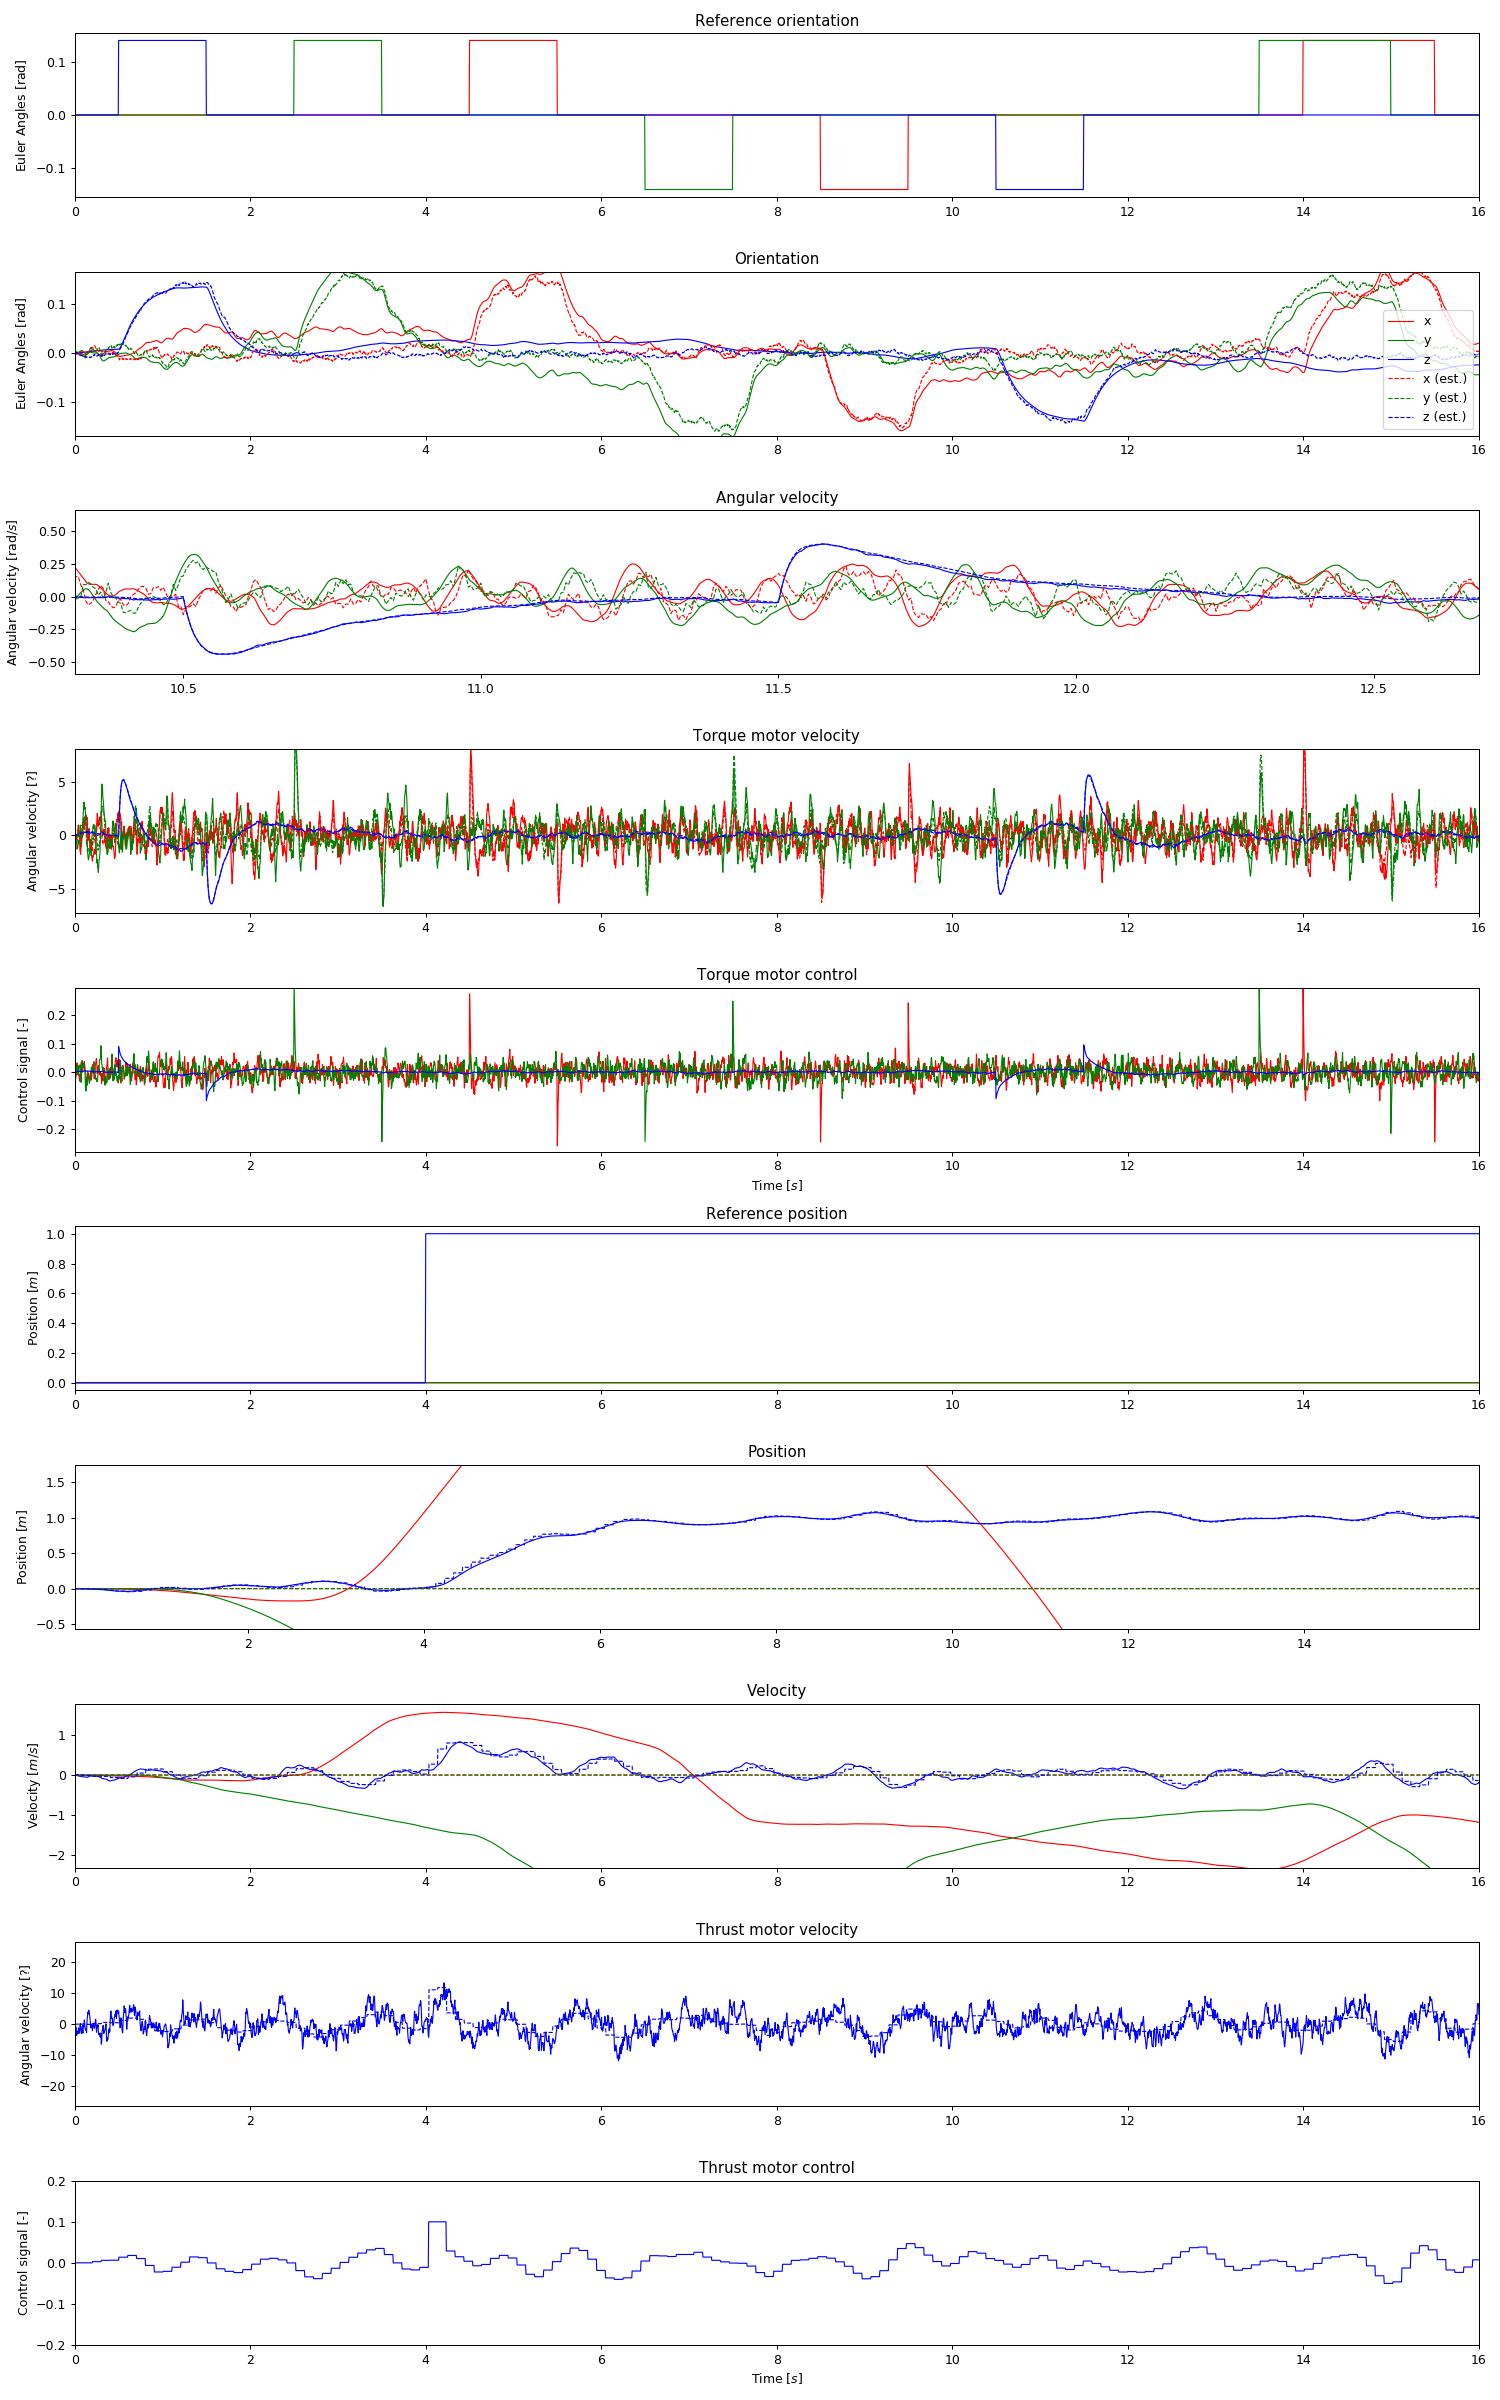

Initial plotting took 994.318 ms


In [6]:
result = d.simulate(controller, observer, randFnW, randFnV, ref_function, x0, odeopt)
start_time = time.time()
fig, lines = DronePlotter.plot(result, vertical=True, w=1500, h=800*3)
end_time = time.time()
print('Initial plotting took {:.3f} ms'.format((end_time - start_time)*1000.0))

def update(**kwargs):
    start_time = time.time()
    # Calculate new parameters
    p = quat_params(**kwargs)
    kwargs['nh'] = p['nh'] * (100 + kwargs['nh_percent']) / 100
    # Override the hovering motor speed
    p = quat_params(**kwargs)
    # Build a new drone model using these parameters
    altered_dp = buildDroneParamsAndMatrices(p)
    print(altered_dp.uh)
    assert(altered_dp.uh <= 0.90)
    assert(altered_dp.uh >= 0.10)
    altered_drone = Drone(altered_dp)
    
    # Design a new controller with the new integral settings, but with the parameters of the original drone
    if kwargs['Ccontrollers']:
        controller = d.getCController(kwargs['config'], kwargs['alt_integral_enabled'])
    else:
        K_pi_alt[3] = kwargs['Ki_alt'] if kwargs['alt_integral_enabled'] else 0
        print(K_pi_alt)
        print(kwargs['maxInt'])
        controller = d.getController(Q_att, R_att, K_pi_alt, kwargs['maxInt'])
    
    # Reset the observer and the random generators (same noise pattern)
    observer.reset()
    randFnW = GaussianNoiseGeneratorInput(varDynamics * kwargs['noise'])
    randFnV = GaussianNoiseGeneratorOutput(varSensors * kwargs['noise'])
    
    new_odeopt = AdaptiveODEOptions(odeopt)  # Make a copy
    new_odeopt.epsilon = kwargs['epsilon']
    
    # Simulate with new drone model
    result = altered_drone.simulate(controller, observer, randFnW, randFnV, ref_function, x0, new_odeopt)
    
    end_time = time.time()
    print('Simulation took {:.3f} ms'.format((end_time - start_time)*1000.0))

    start_time = time.time()
    DronePlotter.update_plot(lines, result)
    fig.canvas.draw()
    end_time = time.time()
    print('Updating plot took {:.3f} ms'.format(
          (end_time - start_time)*1000.0))

def get_sliders():
    display(HTML("<style>.widget-hslider { width:70% !important; }</style>"))
    display(HTML("<style>.widget-inline-hbox .widget-label { width:20% !important; }</style>"))
    return interact(update, 
         m=widgets.FloatSlider(min=1.0,max=3.0,step=0.1,value=1.85,continuous_update=False,description='mass (Model)'),
         tau_m=widgets.FloatSlider(min=0.010,max=0.050,step=0.001,value=0.035,readout_format='.3f',continuous_update=False,description='motor time constant (Model)'),
         Ixx=widgets.FloatSlider(min=0.010,max=0.050,step=0.001,value=0.032,readout_format='.3f',continuous_update=False,description='Ixx (Model)'),
         Iyy=widgets.FloatSlider(min=0.010,max=0.050,step=0.001,value=0.032,readout_format='.3f',continuous_update=False,description='Iyy (Model)'),
         Izz=widgets.FloatSlider(min=0.020,max=0.090,step=0.001,value=0.058,readout_format='.3f',continuous_update=False,description='Izz (Model)'),
         cp=widgets.FloatSlider(min=0.010,max=0.070,step=0.001,value=0.04,readout_format='.3f',continuous_update=False,description='motor power coefficient (Model)'),
         maxInt=widgets.FloatLogSlider(min=-1,max=3,step=0.1,value=maxIntegral,readout_format='.4f',continuous_update=False,description='maximum integral influence (C++)'),
         Ki_alt=widgets.FloatLogSlider(min=-4,max=0,step=0.1,value=abs(K_pi_alt[3]),readout_format='.4f',continuous_update=False,description='altitude integral factor (C++)'),
         alt_integral_enabled=widgets.Checkbox(value=True,description='enable altitude integral (C/C++)'),
         nh_percent=widgets.FloatSlider(min=-10,max=10,step=0.5,value=0,readout_format='.1f',continuous_update=False,description='hovering motor speed error (%) (Model)'),
         Ccontrollers=widgets.Checkbox(value=False,description='C controllers'),
         config=widgets.IntSlider(min=1,max=4,step=1,value=1,continuous_update=False,description='configuration (C)'),
         noise=widgets.FloatSlider(min=0,max=10,step=0.1,value=1,continuous_update=False,description='noise factor (Simulation)'),
         epsilon=widgets.FloatLogSlider(min=-8,max=-3,step=0.1,value=odeopt.epsilon,continuous_update=False,description='epsilon (Simulation)'));

In [7]:
get_sliders();

interactive(children=(FloatSlider(value=1.85, continuous_update=False, description='mass (Model)', max=3.0, mi…